# Introduction to GeoPandas. Part 2


Welcome. This is the second part of the Introduction to GeoPandas Workshop. Today we will be finally talking about [GeoPandas](https://geopandas.org/ "GeoPandas") (gpd). GeoPandas is a very popular tool to explore and manipulate GIS data in Python. As we discovered last time, it is based on Pandas, which entails that it is naturally integrated in many other popular packages. If you plan to create a data analysis pipeline involving GIS data, GeoPandas is likely a good choice.

<div class="alert alert-block alert-success">
<b>More Technical:</b> Throughout the notebook. This kind of boxes provide more technical details on what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

There are four main components in GeoPandas: 
1.   Pandas will handle the data you load;
2.   Fedora will open GIS file of many, many kinds;
3.   Shapely will deal with geometrical operations on the shapes we have;
4.   Matplotlib will plot your maps.

<img src="data/geop_structure.jpg">

<div class="alert alert-block alert-success">
<b>Descartes:</b> To plot, gpd uses a matplotlib-based package named Descartes, which transforms shapely geometrical objects into matplotlib objects. In my own experience, I have rarely interacted with this package myself.
</div>

As a first step, we need to import GeoPandas. Here I also make sure that the version of gpd we are using is up to date. Some of the code I wrote will not work otherwise -- and it is, in general, a good idea to have our package updated when we start a new project.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
# We use shapely a little bit later
import shapely, pyproj
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# This line check the pandas version and it makes sure it is at least 1.0.2
version = pd.__version__.split(".")
print(f"Pandas version: {pd.__version__}")
assert int(version[0]) >= 1
assert int(version[2]) >= 2

# This line checks the version of gpd and makes sure it is >0.7
version = gpd.__version__.split(".")
print(f"GeoPandas version: {gpd.__version__}")
assert int(version[1]) >= 7


Pandas version: 1.0.4
GeoPandas version: 0.7.0


### The Geo in GeoPandas

Last time, we saw that the two main objects in Pandas are Series and DataFrame. You will not be surprised to learn that the main two objects in GeoPandas are the **GeoSeries** and the **GeoDataFrame**. The GeoSeries and GeoDataFrame are really the geographical version of Series and DataFrame: you can handle exactly as you handle ordinary Pandas Series and DataFrame. That is, you can think about the Geo-versions of these objects as having all the methods and attributes of their Pandas' parents. 
There is one main difference, though. GeoSeries and GeoDataFrames have their own specific attributes and methods dealing with the GIS data they contain. We explore this characteristic here. Just for this first exploration, we create a GeoSeries and a GeoDataFrame from scratch. We create 4 points with random coordinates, using numpy to draw random numbers between 0 and 1. 


<div class="alert alert-block alert-success">
<b>Shapely:</b> It is often very useful to know Shapely to manipulate geometrical objects above and beyond what GeoPandas allows you to do. The best resource to learn Shapely (to my knowledge) is its User Manual: https://shapely.readthedocs.io/en/latest/manual.html
</div>


Let's start with creating a GeoSeries. You will remember from last time that Pandas Series can contain different type of data and that different operations are allowed based on the data type. A GeoSeries is specific object from GeoPandas. It is meant to contain one and only one type of data: the `geometry` dtype.  `geometry` is a dtype that is specific to GeoPandas -- you will not find it in Pandas. As the name suggests, it is meant to contain and manipulate information about geometric point in a (2D) space. This is the dtype that will store information about our maps. Leaving the constraints on dtype aside, a GeoSeries behaves exactly as a Series: it has the _shape_ ,  _dtype_ , _index_ and _values_ attributes.

To create the GeoSeries we use the [.points_from_xy( )](https://geopandas.readthedocs.io/en/latest/reference/geopandas.points_from_xy.html#geopandas.points_from_xy, "points_from_xy Documentation") method, which creates a list of shapely points starting from a list (or array) of x coordinates and an array of y coordinates. 

In [5]:
# To create a GeoSeries/GeoDataFrame we need a series of geometrical objects.
# Start with drawing random numbers
np.random.seed(345)
coords = np.random.random((4,2))
print(f"These are the random coordinate:\n{coords}")
# We pass the rows as separate arguments to points_from_xy.
# The first row will become the x coordinates of the points
# The second row will become the y coordinates of the points
pts = gpd.points_from_xy(coords[:,0], coords[:,1])
pts = gpd.GeoSeries(pts)
# Let us see some of the attributes of the GeoSeries
print(f"This is the shape attribute: {pts.shape}")
print(f"This is the dtype attribute: {pts.dtype}")
print(f"This is the index attribute: {pts.index}")
print(f"This is the values attribute:\n{pts.values}\n")
# As usual, the default index is just an ordered array of integers.
# We change the index to something more interesting
new_ind = ['Paul', 'George', 'John', 'Richard']
pts.index = new_ind
print(f"This is the new index attribute: {pts.index}")

These are the random coordinate:
[[0.37092674 0.66488423]
 [0.496658   0.60207905]
 [0.24418494 0.49474806]
 [0.71054041 0.45139238]]
This is the shape attribute: (4,)
This is the dtype attribute: geometry
This is the index attribute: RangeIndex(start=0, stop=4, step=1)
This is the values attribute:
<GeometryArray>
Length: 4, dtype: geometry

This is the new index attribute: Index(['Paul', 'George', 'John', 'Richard'], dtype='object')


GeoSeries and usual Pandas Series can be combined to create a GeoDataFrame. This is like a Pandas DataFrame with a special column storing the shape the geometrical information about the data and a special attribute storing the coordinate system of the data. The special column is indicated as the geometry column of the GeoDataFrame, it is of the `geometry` dtype and it is registered in the _geometry_ attribute of the GeoDataFrame. On a more technical level, the "geometry" column can contain any kind of Shapely geometrical objects: points, polygons, lines and collections of those. We can use any properly-shaped GeoSeries as the geometry column of a GeoDataFrame. Most of the time, this column will also be named as "geometry", even if it can have any arbitrary name.

As for the coordinate system, we will get back to it with real data.

<div class="alert alert-block alert-success">
<b>Multiple Geometries:</b> As the documentation itself acknowledges, things get 'somewhat confusing' with all the different (and important!) things named "geometry" in GeoPandas. To be clear, a GeoDataFrame will always have only one geometry, but it can have more than one column of the geometry dtype and there is no need to have a column named 'geometry'. However, there is the need for a GeoDataFrame to have a geometry in order to access geometry based methods (like plotting).
</div>

Let's build a GeoDataFrame with the GeoSeries we created above as its geometry.

In [6]:
# We will collect few other data in Series in order to create a GeoDataFrame
dob = [1942, 1943, 1940, 1940]
dob = pd.Series(dob)
dob.index = new_ind
most_famous_song = ['Yesterday', 'Here Comes the Sun', 'She Loves You', 'Yellow Submarine']
most_famous_song = pd.Series(most_famous_song)
most_famous_song.index = new_ind
# Now we create a new GeoDataFrame
# Notice that the name of the geometry column is not "geometry"
beatles_gdf = gpd.GeoDataFrame({'dob': dob, 'song': most_famous_song, 'geometry': pts})
# As usual we use .head() to see the first (and only) lines
print(f'This is the GeoDataFrame:\n{beatles_gdf}\n\n')
# Since we passed a column named "geometry", GeoPandas rightly guessed this is the column we wanted as our geometry
# This is pretty standard practice
print(f'This is the geometry attribute of the GeoDataFrame:\n{beatles_gdf.geometry}\n')
# If you are wondering which column is set as a geometry, it is registered in the geometry.name attribute
print(f'This is the name of the column containing the geometry: {beatles_gdf.geometry.name}')

This is the GeoDataFrame:
          dob                song                 geometry
Paul     1942           Yesterday  POINT (0.37093 0.66488)
George   1943  Here Comes the Sun  POINT (0.49666 0.60208)
John     1940       She Loves You  POINT (0.24418 0.49475)
Richard  1940    Yellow Submarine  POINT (0.71054 0.45139)


This is the geometry attribute of the GeoDataFrame:
Paul       POINT (0.37093 0.66488)
George     POINT (0.49666 0.60208)
John       POINT (0.24418 0.49475)
Richard    POINT (0.71054 0.45139)
Name: geometry, dtype: geometry

This is the name of the column containing the geometry: geometry


You may be wondering what is so special about the geometry column of a GeoDataFrame. The data in this column is used in all the methods and attributes dealing with geometrical properties. Following there are few examples of these methods. Here we use [.buffer( )](https://geopandas.org/geometric_manipulations.html#geoseries.buffer, ".buffer() Documentation"), [.envelope](https://geopandas.org/geometric_manipulations.html#geoseries.envelope, ".envelope() Documentation"), [.area](https://geopandas.org/geometric_manipulations.html#geoseries.area, ".area Documentation") and [.boundary](https://geopandas.org/geometric_manipulations.html#geoseries.boundary, ".boundary Documentation").

The geometry column is also what is plotted by the .plot() method of a GeoDataFrame. We use it here to show the various transformations visually, but we will talk about it a little later.

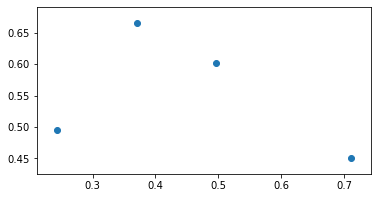

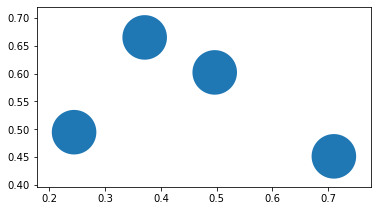

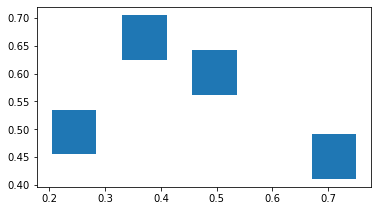

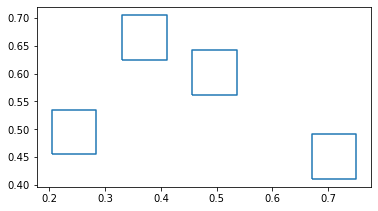

In [7]:
# You can plot the geometry -- more on this later
beatles_gdf.plot()
# You can expand the points into circles with buffer
beatles_gdf['geometry'] = beatles_gdf.buffer(0.04)
beatles_gdf.plot()
# You can create rectangles around it!
beatles_gdf['geometry'] = beatles_gdf.envelope
beatles_gdf.plot()
# You can ask for the boundary -- the points delimiting the objects in the geometry
beatles_gdf = beatles_gdf.boundary
beatles_gdf.plot()

#### Your turn!

I have set up two lists. The first list contains two Shapely geometrical objects -- namely, a LineCollection. The second list contains two strings. The final objective is to create a GeoDataFrame having the LineCollection as a geometry, plot it, get its area and the rotate it by 90 degrees. 

To get the area of a geometry you can use the [.area](https://geopandas.org/geometric_manipulations.html#geoseries.area, ".area Documentation") attribute. To rotate a geometry you can use the [.rotate( )](https://geopandas.org/geometric_manipulations.html#geoseries.rotate, ".rotate( ) Documentation"). Look in the comment for suggestions.



0    0.0
1    0.0
dtype: float64


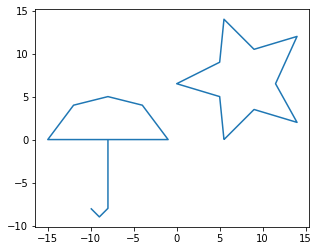

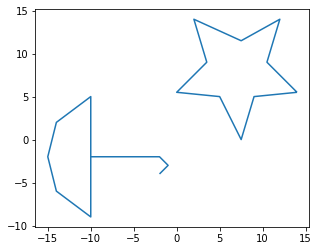

In [8]:
# These lines are just creating the right types of geometrical objects with the right coordinates
coords1 = [((5.5, 0), (5,5), (0, 6.5), (5, 9), (5.5, 14), (9, 10.5), (14, 12), (11.5, 6.5), (14, 2), (9, 3.5), (5.5, 0))]
coords2 = [((-10, -8), (-9,-9), (-8,-8), (-8, 0)), ((-8, 0), (-1,0), (-4,4), (-8,5), (-12,4), (-15, 0), (-8, 0))]
geom1 = shapely.geometry.MultiLineString(coords1)
geom2 = shapely.geometry.MultiLineString(coords2)

# These are the two lists mentioned in the prompt
list_geom    = [geom1, geom2]
list_strings = ['Starman', 'Singing in the Rain']

# Create a GeoDataFrame
new_gdf = gpd.GeoDataFrame({'Titles': list_strings , 'geometry': list_geom})

# plot it
new_gdf.plot()
# Rotate the geometry by 90 degress.
# For example, new_gdf.rotate(180) will rotate the geometry by 180 degrees
new_gdf['geometry'] = new_gdf['geometry'].rotate(90)
# plot the rotate geometry
new_gdf.plot()

# Get the area of the geometry
print(new_gdf.area)
# Why these values for the area?
# Because the objects in the geometry are lines. Lines have no area

### Data Analysis with GeoPandas

Rotating umbrellas and stars is fun. However, it turns out, this is not why GeoPandas is so popular. In the rest of the notebook we will work with real data detailing residential segregation. Sorry for the change in mood, but I wanted to show you a more realistic setting and I used my own research as a blueprint. We will answer the following question: does redlining from the Thirties still predicts the racial residential patterns in 2010?

We will be using data from two sources. First, we have 2010 Census data about blockgroups in Cook County. A block group is the smallest geographical area for which the US Census Bureau publicly distributes data -- for smaller areas, privacy concerns outweights the benefit of distributing the data. The shapefile we are going is a map of blockgroups in Cook County. It is distributed freely by the Census Bureau under the name of 2010 TIGER/Line+ shapefile. I worked on the GeoDataFrame a little so that it contains a column showing the 2010 population block by block -- this data comes from 2010 Census.

Second, we will be using the Home Owner's Loan Corporation (HOLC) maps for Chicago. HOLC was a federally-mandated company that insured mortgages to buy new houses. HOLC was part of the New Deal and used federal money to do this. It helped a lot of young couples to buy a house by lowering the interest rates on the mortgage the couple could get. HOLC assessed the risk of insuring a mortgage based on complete maps of US cities. These maps qualified each block in a city in four grades (green = very good, red = very bad). Unfortunately, red blocks mapped very clearly with blocks where minorities (South Europeans or Blacks) resided and HOLC was quite explicit about their racial policy -- from here the name "redlining". Recently, a team of researchers from the University of Richmond, Virginia Tech, Univerisity of Maryland and Johns Hopkins University digitized the original maps and made them freely available to the public. We acknowledge their great work and thanks their generosity. You can find more information on this project at: https://dsl.richmond.edu/panorama/redlining/#loc=5/39.1/-94.58 .



First things first, we need to load the data. Normally, we would have the data in our HD or on a Server we can access (like Quest). For the purpose of this worshop, we will be downloading the data directly from the internet -- specifically from the GitHub repository of this workshop. Beware, because of the downloading, it may take a minute to run this block.

In [9]:
# Shapefiles are a set of files. It is often convenient to store them in a compressed folder.
# Geopandas will deal with zipped folder containing the files just as easily. 
# Notice that we are even giving gpd an url, the file is not on our HD. But gpd is smart enough to
# understand we are giving him an internet address, download the file in memory and open it.
# Naturally, if you plan to work with a shape file periodically, or the file is particularly big, 
# it is way more convenient to have a local version of the shapefile. But this is still very cool.
url_blkgrp    = r'https://github.com/non87/GeoPandas-Workshop/blob/master/data/grpblk/grpblk.zip?raw=true'
url_redlining = r'https://github.com/non87/GeoPandas-Workshop/blob/master/data/redlining/redlining.zip?raw=true'
blk = gpd.read_file(url_blkgrp)
rdl = gpd.read_file(url_redlining)

I mentioned above that the coordinate system of the data is stored in an attribute of the GeoDataFrame. This attribute is the [.crs](https://geopandas.org/reference.html#geodataframe, ".csr Documentation") of the GeoDataFrame. Crs stands for Coordinate Reference System. There are many existing projection and the .crs attribute takes care of managing those for us. Here we will convert the two GeoDataFrame we just loaded to the same crs. 

By the way, there are deep mathematical reasons why a 2d map of the surface of a spheroid necessarily deforms the represented space. This means that the distances and areas we calculate in our data may be grossly wrong -- GeoPandas treats everything as if we are in a traditional Euclidean 2-dimensional space. This effectively entails that some projections will work better (or worst) for a given project. It turns out that geographers at the federal government, created regional-level projections for the US. These projections are very precise when applied to region they were created for (and they are completely unreliable elsewhere). We will be using the regional IL projection for this workshop. You will see, the final map looks quite different when we convert the data to this projection.

There are various ways in which we can change the crs of a GeoDataFrame. Whenever possible, the recomandation is to use the EPSG code of the projection. This is a series of number that uniquely identifies a projection. It was originally created by European Petroleum Survey Group. Usually you can simply Google it and it will easily shows up.  This method suffices 99.9% of the time, if we are not specifically working on coordinate reference systems. In our case, however, the federal source I found does not provide such a code. I will show you how to find it (if it exists) using the pyproj package.

This is the original blk coordinate system: epsg:4269

This is the original rdl coordinate system: epsg:4326

This is the new crs of blk: epsg:3435

This is the new crs of rdl: epsg:3435



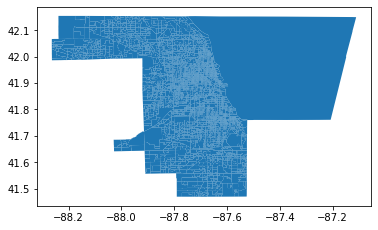

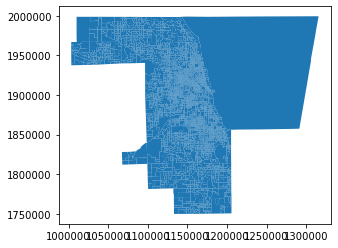

In [10]:
# Let's check the crs attributes of both gdf

print(f'This is the original blk coordinate system: {blk.crs}\n')
print(f'This is the original rdl coordinate system: {rdl.crs}\n')
# Good so both files came with their own crs.
# Let's plot blk to see how it looks like
blk.plot()
# It is still not the crs we want.
# We create the Illinois regional crs by mean of the PROJ string I found.
# Honest confession: I don't know how to read a PROJ string, but it works.
# Pyproj and Geopandas will know what to do with it.
il_proj = "+proj=tmerc +lat_0=36.66666666666666 +lon_0=-88.33333333333333 +k=0.9999749999999999 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs "
# This is from pyproj
il_crs = pyproj.CRS(il_proj)
# This will give you the epsg number
epsg_numb = il_crs.to_epsg()
# and this will actually change the crs of the data
blk = blk.to_crs(epsg_numb)
rdl = rdl.to_crs(epsg_numb)
print(f'This is the new crs of blk: {blk.crs}\n')
print(f'This is the new crs of rdl: {rdl.crs}\n')
# We can see the new projection has no name, but it works nonetheless
blk.plot()

Leaving aside the geometry and the crs, a GeoDataFrame is still a DataFrame. So we will use the same method we saw last time to inspect it.

In [11]:
print(f"First five lines of blk:\n{blk.head()}\n\n")
print(f"Info for blk:\n{blk.info()}\n\n")
print(f"First five lines of rdl:\n{rdl.head()}\n\n")
print(f"Info for rdl:\n {rdl.info()}")

First five lines of blk:
  STATEFP10 COUNTYFP10 TRACTCE10 BLKGRPCE10                GEOID10  \
0        17        031    242700          1  1500000US170312427001   
1        17        031    242600          4  1500000US170312426004   
2        17        031    242600          3  1500000US170312426003   
3        17        031    242600          2  1500000US170312426002   
4        17        031    242600          1  1500000US170312426001   

      NAMELSAD10 MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10  \
0  Block Group 1   G5030          S   175573         0  +41.8974254   
1  Block Group 4   G5030          S   103409         0  +41.8979333   
2  Block Group 3   G5030          S   123995         0  +41.8979592   
3  Block Group 2   G5030          S   123914         0  +41.9015827   
4  Block Group 1   G5030          S   124426         0  +41.9043164   

     INTPTLON10  TOTAL  WHITE  BLACK  \
0  -087.6993743  702.0  321.0  191.0   
1  -087.6955258  452.0  297.0   57.0   
2  -087

From this first exploratory steps, it is immediately clear we need to do some data cleaning. 

The blk GeoDataFrame clearly contains blockgroups that are largely just water. Let's get rid of these. The columns 'AWATER10' and 'ALAND10' contains the area of covered by water and land respectively for each blockgroup. 

     STATEFP10 COUNTYFP10 TRACTCE10 BLKGRPCE10                GEOID10  \
2304        17        031    990000          0  1500000US170319900000   

         NAMELSAD10 MTFCC10 FUNCSTAT10  ALAND10    AWATER10   INTPTLAT10  \
2304  Block Group 0   G5030          S        0  1717090426  +41.9739391   

        INTPTLON10  TOTAL  WHITE  BLACK  \
2304  -087.4002947    0.0    0.0    0.0   

                                               geometry  
2304  POLYGON ((1198527.586 1857948.997, 1197988.146...  


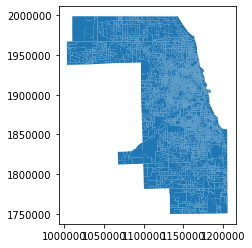

In [12]:
# Let's select those blk that are 95% water
print(blk.loc[(blk['AWATER10' ]/(blk['AWATER10']+blk['ALAND10'])) > 0.95, :])
# There is just one block with this characteristic and it is enormous
# Let's get rid of this
blk = blk.loc[(blk['AWATER10' ]/(blk['AWATER10']+blk['ALAND10'])) <= 0.95, :]
# Much better!
blk.plot()

The rdl GeoDataFrame contains the enterity of the US. Most of this is not relevant for us. We need to find only those blocks we are interested in -- that is the blocks in Cook County. The easy way is to select all the blocks in IL. Then we need to be sure we get the blocks in Cook County, and only those.

We will use the [.unique( )](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html?highlight=unique#pandas.Series.unique, ".unique( )") method to get the surveyed cities in Illinois. As the name suggests, .unique( ) will output all the different values in a Series. Reminder: Each column in a (Geo)DataFrame is a Series, so we can use .unique( ) to check the unique values of a column.

In [13]:
# Filter for IL
rdl = rdl.loc[rdl['state'] == 'IL']
print(f"These are the cities in IL: {rdl['city'].unique()}")
# Easy enough: we will just look at the Chicago block
rdl = rdl.loc[rdl['city'] == 'Chicago']

These are the cities in IL: ['Aurora' 'Chicago' 'Decatur' 'East St. Louis' 'Joliet' 'Rockford'
 'Springfield']


#### Creating Maps with GeoPandas

The columns "WHITE" and "BLACK" from the blockgroups map are what we will be using in our analysis. A first step will be to map the two populations their distribution in Chicago and then compare it to the map of HOLC blocks. Here we will look at the [.plot( )](https://geopandas.readthedocs.io/en/latest/mapping.html#mapping, "User Guide to mapping") method of the GeoDataFrame in more details. 

<div class="alert alert-block alert-success">
<b>cmap:</b> A color map (cmap) is a function mapping number to colors. Beware that the cmap of a plot may change the readers' interpretation of the plot, all else being equal. GeoPandas is based on matplotlib and supports all pre-defined cmaps already present in matplotlib. You can also create your own cmap and pass it to the GeoPandas plotter, as shown in the code. For more information about cmap and a list of existing cmaps:
https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
</div>

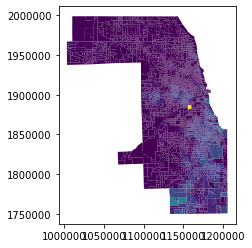

In [14]:
# To plot a Cloropleth map, we can pass the column keyword. For example
blk.plot(column = 'BLACK')

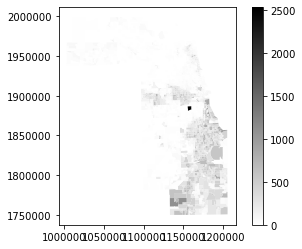

In [15]:
# We can change the colorscheme using the cmap keyword. 
# We will also add a legend using the legend keyword.
blk.plot(column = 'BLACK', legend = True, cmap = 'gist_gray_r')

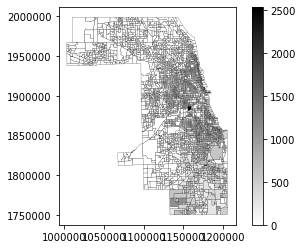

In [16]:
# Almost there. We need to make sure the dividing lines of the blocks are shown
# Otherwise we will not be able to see the plot at all (since the background is white)
blk.plot(column = 'BLACK', legend = True, cmap = 'gist_gray_r', linewidth=0.2, edgecolor='black')

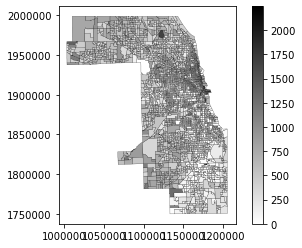

In [17]:
# Good, now the WHITE column. Same exact arguments
blk.plot(column = 'WHITE', legend = True, cmap = 'gist_gray_r', linewidth=0.2, edgecolor='black')

You may notice that the maps are not properly comparable because the scale of the columns is widely different -- the BLACK picks over 2,500 while the WHITE column picks at roughly 2,000. We tackle this issue in the Extra session below. Now we proceed with plotting of the redlining map _over_ the map of the black population.

We need a little preparation to create the plot we want!

In [18]:
# We need a slight bit of matplotlib to do map overlay.
from matplotlib.colors import ListedColormap 

# We start by mapping the rdl holc_grade column to numbers.
# Ultimately, we always want to input numbers in matplotlib
grade_dic = {"A": 0, "B": 1, "C": 2, "D": 3}
# We create a specific cmap for this plot. 
# We use one of matplotlib's special function for this
# The newly created map will map 0 to green, 1 to blue, etc.
cmap_rdl = ListedColormap(['green', 'blue', 'yellow', 'red'], name='holc_cmap')
# Now we substitue the original data in the holc_grade column with its mapped numbers
rdl['holc_grade'] = rdl['holc_grade'].apply(lambda x: grade_dic[x])
print(f'The dtype of the holc_grade column now is: {rdl["holc_grade"].dtype}')

The dtype of the holc_grade column now is: int64


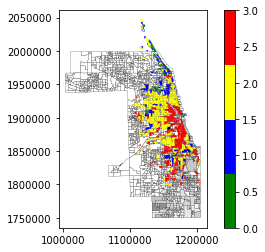

In [19]:
# Now we can start to plot. Again need a little of matplotlib syntax
fig, ax = plt.subplots()
# This is exactly the same plot as before, but notice the argument ax
blk.plot(column = 'BLACK', cmap = 'gist_gray_r', 
         linewidth=0.2, edgecolor='black', ax = ax)
# By passing the same value to the ax argument, we can overlay maps
rdl.plot(column = 'holc_grade', legend = True, cmap = cmap_rdl, 
         linewidth=0, ax = ax)

One of the (many) problems of this plot is that the HOLC blocks completely cover what behind them, making the information unreadable. We address this issue below.

However, the other big issue regard the confusing and uninformative legend. Creating a good legend for this plot is well outside the scope of this workshop -- see below for some hint. 

Naturally, another problem regards the dimensions of the plot, but this is a lesser problem. In actual research, we would save the image on our HD with an appropriate size -- in my own research, this map is a png image occupying roughly 6MB.

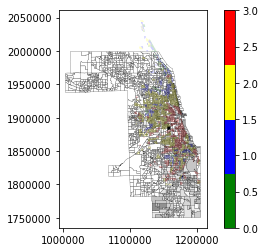

In [20]:
# To make sure that the HOLC information does not
# completely obscure the other information, we need to make it semi-transparent
# We use the argument alpha for this
fig, ax = plt.subplots()
blk.plot(column = 'BLACK', cmap = 'gist_gray_r', 
         linewidth=0.2, edgecolor='black', ax = ax)
# Notice alpha
rdl.plot(column = 'holc_grade', legend = True, cmap = cmap_rdl, 
         linewidth=0, ax = ax, alpha = 0.2)

Had the cmap of the BLACK column been actually informative, we would notice that the redlined block still align quite well with the density of the black population. However, plotting may not be enough.

##### Extra Material on Mapping

Let's ameliorate the previous plot by making the scale for the BLACK column more readable. The plot will still not be perfect, but it will definitely be clearer. You may notice that the BLACK and WHITE maps are not properly comparable because the scale of the columns is widely different -- the BLACK picks over 2,500 while the WHITE column picks at roughly 2,000. One may wonder:

1.   What is happening with the BLACK column? What is that enourmous concentration of black people in the middle of Cook County? How comes that the max value of the BLACK column is so much bigger than the max value of the WHITE column while, at the same time, the black population is roughly one third of the white population?
2.   Can we put the two maps on the same scale and, at the same time, make the map of the black population more legible? You may notice that the 7,000 block is actually making the map difficult to read because every other block has much less black population. This entails that the color of all other blocks will be more or less the same and the map will not provide much visual clue about the variation of the BLACK variable beyond its concentration in the 7,000 block. 

###### The 2,500 block

May this be a data issue? Is the Census data wrong? No, unfortunately. The Census data is capturing the reality of mass incarceration in the US. It turns out that the 2,500 block is occupied by the Cook County Jail. Veryfing this in GeoPandas is an interesting exercise. 

We start by Googling the lat-long coordinates of the jail, see the image.

<img src="data\CCDOC.png">

Now we can input these in a GeoSeries, translate the long-lat coordinate in the regional coordinate system we are using,  plot the result onto the BLACK map to see that the positions of the 2,500 block and of the jail coincides. Here we use the fact that GeoSeries have a .crs( ) attribute as well and can handle the same kind of crs transformations that a GeoDataFrame handles.

In [ ]:
# From Google, these are the long-lat coordinate of Cook County Jail
jail = [-87.6971, 41.8425]
jail = gpd.GeoSeries(shapely.geometry.Point(jail))
# EPSG:4326 is the long-lat crs
# This line is making clear to GeoPandas what it is dealing with
jail.crs = "EPSG:4326"
jail = jail.to_crs(epsg_numb)

In [ ]:
fig, ax = plt.subplots()
blk.plot(column = 'BLACK', cmap = 'gist_gray_r', 
         linewidth=0.2, edgecolor='black', ax = ax)
# We overlay the jail as a red point
# Notice the color and markersize arguments
jail.plot(color = 'red', markersize=5, ax = ax)
# We see the red point on top of the block causing issues
# The jail is indeed the problem!

###### Controlling the Scale

As a last effort, we will change the scale of the BLACK plot so that it matches the scale of the WHITE plot. This may not be the right strategy to change the scale. Specifically, using the same scale as the WHITE scale will entail flattening the cmap beyond the max value of the WHITE variable. That is, any block with a BLACK variable bigger than the max value of the WHITE variable  will have the same, solid-black color. This way, we may be losing information. So, let's check what we are losing.

In [ ]:
print(blk.loc[blk['BLACK']>blk['WHITE'].max(), 'BLACK'])

Once we are clear about the fact that the Cook County Jail datapoint is skewing all the data and therefore will be substantially ignored, our map will not conceal any information about any other block. This way, we achieve a much greater clarity in the map and a direct comparability of the WHITE and BLACK variable distributions.

In [ ]:
# To control the scale of the variable, 
# we will indicate the relevant interval to the .plot( ) method
# using the vmin and vmax arguments.
# vmin is 0 since this is the natural lower bound for this variable
# vmax is capped at the max for the WHITE variable
blk.plot(column = 'BLACK', cmap = 'gist_gray_r', 
         linewidth=0.2, edgecolor='black',
        vmin = 0, vmax = blk['WHITE'].max())

To see the difference between the distribution of the black and white population we can plot the BLACK and WHITE maps alongside each others. 

In [ ]:
# We use matplotlib subplots function to get the maps side by side
fig, ax = plt.subplots(1,2)
# notice the ax parameter in both calls to plot()
blk.plot(column = 'BLACK', cmap = 'gist_gray_r', 
         linewidth=0.2, edgecolor='black', ax = ax[0],
        vmin = 0, vmax = blk['WHITE'].max())
blk.plot(column = 'WHITE', cmap = 'gist_gray_r', 
         linewidth=0.2, edgecolor='black', ax = ax[1])
# These lines take out the useless ticks from the x and y axes
ax[0].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax[1].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

Finally, we remake the plot showing the HOLC block colors over the BLACK distribution. Even if the plot is far from perfect, you would see in a bigger figure that the map is now much clearer.

In [ ]:
# overlay the HOLC map with the BLACK distribution.
fig, ax = plt.subplots()
blk.plot(column = 'BLACK', cmap = 'gist_gray_r', 
         linewidth=0.2, edgecolor='black', ax = ax,
        vmin = 0, vmax = blk['WHITE'].max())
rdl.plot(column = 'holc_grade', legend = True, cmap = cmap_rdl, 
         linewidth=0, ax = ax, alpha = 0.3)

#### Your turn!

In the blk data, you can see there is a "ALAND10" and a "AWATER10" column showing how many women and men live in a block. Construct a new column named "density" containing the density of the total population. Map it using a different cmap from the cmap using above. You can find a list of available cmaps [here](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#, "Cmaps List"). 

As an additional exercise, use the .area attribute of the blk to calculate the density based on the shape area. Then, convert the GeoDataFrame to EPSG:32616 -- this a popular reference system that covers between 90°W and 84°W, northern hemisphere between equator and 84°N. Calculate the density again. How does it compare to the density calculated from the regional Illinois CRS?

This is the difference with the Illinois specific CRS:0.053116161584546975
This is the difference with the less specific CRS:1.7321095782580316


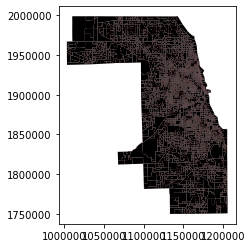

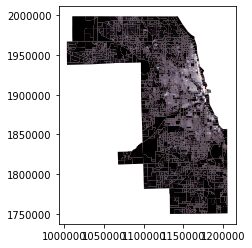

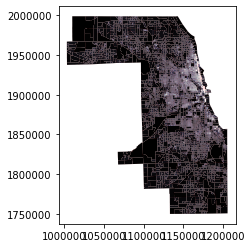

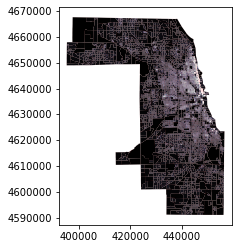

In [21]:
# Beware that ALAND10 and AWATER10 are in m^2. We will use km^2.
# This lines do the conversion
blk['AWATER10'] = blk['AWATER10']*0.000001
blk['ALAND10']  = blk['ALAND10']*0.000001
# Density is numb. of people divided by total area.
# Construct the new column using the 'TOTAL' column at the numerator
blk['density']  = blk['TOTAL']/(blk['AWATER10']+blk['ALAND10']) 
# plot it
blk.plot(column = 'density', cmap = 'bone', 
         linewidth=0.02, edgecolor='red',
        )
# It turns out that the map is not very informative
# The problem is always the same: there is one block with sky high density
# Controlling the scale we get a much more informative view
blk.plot(column = 'density', cmap = 'bone', 
         linewidth=0.02, edgecolor='red',
         vmin = 0, vmax = 8000)

# Second part
# Calculate the area from GeoPandas
blk['area_crs0'] = blk.area
# Beware this is in feet squared. This line will convert it to km^2
blk['area_crs0'] = blk['area_crs0'] * 0.09290304 * 0.000001
# Calculate the new density
blk['density_crs0'] = blk['TOTAL']/(blk['area_crs0'])
# plot density again
blk.plot(column = 'density_crs0', cmap = 'bone', 
         linewidth=0.02, edgecolor='red',
         vmin = 0, vmax = 8000)
# Convert the crs EPSG:32616
blk = blk.to_crs(32616)
# Calculate the area again
blk['area_crs1'] = blk.area
# This time the area in m^2. Convert it to km^2
blk['area_crs1'] = blk['area_crs1']*0.000001
# Calculate the new density
blk['density_crs1'] = blk['TOTAL']/(blk['area_crs1'])
# plot it
blk.plot(column = 'density_crs1', cmap = 'bone', 
         linewidth=0.02, edgecolor='red',
         vmin = 0, vmax = 8000)
blk = blk.to_crs(epsg_numb)

# What is the difference?
# There are many ways to assess the difference.
# Here, I simply take the mean (of the absolute value) of the difference 
# between the GeoPandas-based densities and 
# the density based on the Census areas
mn_diff_crs0 = (blk['density_crs0'] - (blk['density'])).abs().mean()
print(f'This is the difference with the Illinois specific CRS:{mn_diff_crs0}')
mn_diff_crs1 = (blk['density_crs1'] - (blk['density'])).abs().mean()
print(f'This is the difference with the less specific CRS:{mn_diff_crs1}')
# We see the regional CRS is substantially closer to the 'true' value
# But, is this difference substantially meaningful? Depends on your questions!

### Geometrical Manipulation

GeoPandas truly shines because of its built-in integration with Shapely. Shapely lets you do very powerful manipulation of your current geometry with an easy (in my opinion) syntax. Here, I showcase a little of this power. We will continue exploring the relationship between residential segregation and redlining by constructing a tabulation of where the white and black population lives. Specifically, we will be looking at the HOLC grade assigned to the block where black and white individuals live and then construct a table of race by holc grade. 

The difficulty of this analysis is that HOLC blocks do not correspond to current Census blocks. In a database terminology we would say there is a many to many relationship. For didactical purposes, we will be using a simple approach to this issue. We will condense each block into one point (its centroid) and then check in which kind of HOLC block the centroid falls. This will be done with the [.contains( )](https://shapely.readthedocs.io/en/latest/manual.html#object.contains, ".contains( ) Documentation") method of Shapely objects. As the name suggests, .contains( ) checks if a shape (a point in this case) is contained within another shape (a polygon). We will also create a special class of blocks that are not in any HOLC block. Finally, we will use the [.groupby( )](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html?highlight=groupby#pandas.DataFrame.groupby, ".groupby( ) Documentation") method of the DataFrame object to see how many black and white individuals live in the different kinds of HOLC blocks.

<div class="alert alert-block alert-success">
<b>Rtree:</b> In the next block we are going to check if a point (representing an entire block) is contained in any HOLC block. There are 3992 points and 580 HOLC blocks. Therefore, we are going to perform 3992 * 580 = 2,315,360 checks. As you will see, the code turns out to be surprisingly quick, but this kind of checks are in general a bottleneck in the code. In cases where the code is slower, you should implement a spatial index. This is native feature of GeoPandas that makes geometrical checks like these much quicker. A spatial index use the concept of rectangular trees, from here the name of rtree. See this post for an introduction: https://geoffboeing.com/2016/10/r-tree-spatial-index-python/</div>

In [22]:
# To create the centroid, we can use the centroid method from GeoPandas!
blk['centroid'] = blk.centroid
# Now, we map each block to a HOLC grade.
# We also need to consider those Census blocks that are not within any HOLC blocks
holc_grades = []
for id_, p in blk['centroid'].iteritems():
    # Create a boolean series checking if the point is within a HOLC block
    bool_ser = rdl['geometry'].apply(lambda x: x.contains(p))
    # We are interested only those values that are True from the series
    # reminder: False = 0 and True = 1 when added together. 
    # s will contain the total number of True in the bool_ser variable
    s = bool_ser.sum()
    if s == 0:
        # We put -1 to signal that no HOLC grade was ever given to a block
        holc_grades.append(-1)
    else:
        # There will always be at most one HOLC block for any Census block
        # Thus this selection will output one and only one element
        holc_grades.append(rdl.loc[bool_ser, 'holc_grade'].values[0])
blk['holc_grades_cent'] = holc_grades
# Create the table using the .groupby() method of DataFrames
table = blk.loc[:,['holc_grades_cent', 'BLACK', 'WHITE']].groupby(
    'holc_grades_cent').sum()
print(f'Distribution of the black and white population in different kinds of HOLC blocks in Cook County:\n{table}')

Distribution of the black and white population in different kinds of HOLC blocks in Cook County:
                     BLACK     WHITE
holc_grades_cent                    
-1                170800.0  643991.0
 0                   595.0   13728.0
 1                 41697.0   82452.0
 2                158402.0  332451.0
 3                105535.0  123568.0


### The Last Exercise

Ok, we got to the end of the workshop. As a mentioned last time, a single workshop cannot explore the entire extent of packages as Pandas or GeoPandas. However, we came a long way and now you know most important concepts and you are ready to code on your own...well with the official documentation on as your helper.

Following this spirit, this exercise will focus on something we have not encountered so far, but that is very helpful to know. Merging dataframes. You will need to enrich the blk dataframe with other data provided by the Census and use the [.merge( )](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html?highlight=merge#pandas.DataFrame.merge, ".merge( ) Documentation") method to do this. In this exercise, we will be looking at income residential segregation in Cook County. We will be comparing income segregation in 2010 and 2017, based on the American Community Survey 5-years estimates.

This is a longer exercise divided into three parts.

In [ ]:
# To measure income segregation, we need income data
# Read in the income data. These files contains
# the number of households in Census pre-defined income brackets
# for each group of blocks in Cook County. These are the url to the data
url1 = 'https://raw.githubusercontent.com/non87/GeoPandas-Workshop/master/data/grpblk/inc_2013.csv'
url2 = 'https://raw.githubusercontent.com/non87/GeoPandas-Workshop/master/data/grpblk/inc_2017.csv'
# inc13 = ...
# inc17 = ...
# As often the case with Census file, the column names are mysterious
# Use this dictionary along with the .rename( ) method to make things better
col_names_dic = {'GEO_ID': 'GEOID10'      , 'B19001_002E': '<10k'    , 
                 'B19001_003E': '10_15k'  , 'B19001_004E': '15_20k'  ,
                 'B19001_005E': '20_25k'  , 'B19001_006E': '25_30k'  ,
                 'B19001_007E': '30_35k'  , 'B19001_008E': '35_40k'  ,
                 'B19001_009E': '40_45k'  , 'B19001_010E': '45_50k'  ,
                 'B19001_011E': '50_60k'  , 'B19001_012E': '60_75k'  ,
                 'B19001_013E': '75_100k' , 'B19001_014E': '100_125k',
                 'B19001_015E': '125_150k', 'B19001_016E': '150_200k',
                 'B19001_017E': '>200k'   , 'B19001_001E': 'TOTAL'
                }
# Use rename and col_names_dic to rename the columns of the df
# inc13 = ...
# inc17 = ...
# Using the dic we save a list of columns we would like to retain.
# The other columns in the data are not relevant for us.
# We use a list comprehension for this
retain = [it for k, it in col_names_dic.items()]
# Drop those columns that are not in retain using a selection.
# This is just for our own clarity while working with data
# inc13 = ...
# inc17 = ...
# The first row of the df is troublesome
# This is another common feature of Census data.
# Delete it from both df using the .drop( ) method of dataframes
# inc13 = ...
# inc17 = ...
# Notice that the dtypes of the df are wrong
# This is due to the row we just deleted.
# This is a list containing the names of the columns to convert
conv_cols = [col for col in retain if col != 'GEOID10']
# Convert them to the right dtype (int32 will do)
#...

After loading and cleaning the Census data we can focus on our objective. Our strategy to measure income segregation will be mapping the proportion of households with income below the median. The median income in 2017 is 59,426 dollars. The median income in 2013 is 54,548 dollars. FIY these are the median incomes in Cook County. The national median incomes are lower. In this block, we prepare the data for merging.

In [ ]:
# These two variables contains the median income of 2013 and 2017
med13 = 54548
med17 = 59426
# Now we need to determine how many households have an income above the
# median in each group of blocks.

# First: sum the number of families that are certainly below the median
# You may find helpful to have this list of col names
brackets_below = ['<10k', '10_15k', '15_20k', '20_25k', '25_30k', '30_35k',
                  '35_40k',  '40_45k', '45_50k']
# Try using the .sum() method on a selection
# inc13['below'] = ...
# inc17['below'] = ...

# Here we encounter another common problem:
# the median falls within an income bracket and we don't know how
# to estimate the number of families who are above or below the median within this bracket
# Here we take the simplistic approach that income is uniformly
# distributed within income brackets. More sophisticated approaches exist.
bracket_within = ['50_60k']
# This is the simple estimate, rounded to nearest integer
approx13 = np.round(inc13[bracket_within].to_numpy()*((med13 - 50000)/10000))
approx13 = approx13.reshape((approx13.shape[0], ))
approx17 = np.round(inc17[bracket_within].to_numpy()*((med17 - 50000)/10000))
approx17 = approx17.reshape((approx17.shape[0], ))
# We add the estimate to the what we already calculated
inc13['below'] = inc13['below'] + approx13
inc17['below'] = inc17['below'] + approx17

# Finally, calculate the proportion of households below the median
# We add the year to the column name to facilitate the merging later
# inc13['prop_below_13'] = ...
# inc17['prop_below_17'] = ...
# Notice there will be NaNs in those blocks who have 0 population

# Before merging it is convenient to drop all columns we don't care about
# in our case, we only care about the proportion and GEOID10.
# Use a selection to drop the other columns
# inc13 = ...
# inc17 = ...

Here we finally merge the Census data with the blk GeoDataFrame and plot the proportion of households below the median in 2013 and 2017.

In [ ]:
# Use .merge( ) to merge the inc13 data with blk
# blk = ...
# Same for inc17
# blk = ...
# A quick check of how blk looks like now
print(blk.head())
# Plot the proportion below median income in 2013
# Use "vmin = 0, vmax = 1" to make sure the scale goes from 0 to 1
#blk.plot(...)
# Plot the proportion below median income in 2017
# As before, "vmin = 0, vmax = 1" to make sure the scale goes from 0 to 1
#blk.plot(...)

# A little extra, a map of the differences between the proportions in the two years
# to see change more clearly. Beware, we need to use a diverging cmap
blk['prop_diff'] = blk['prop_below_17'] - blk['prop_below_13']
blk.plot(column = 'prop_diff', cmap = 'RdGy', vmin = -1, vmax = 1,
         linewidth=0.2, edgecolor='black', legend = True)
